# Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from trendfilter import trend_filter

# Data

In [2]:
train_events = pd.read_csv("train_events.csv")

In [3]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
no_NaN_series = series_has_NaN[~series_has_NaN].index.tolist()
# also drop these two "truncated" events series seen in EDA:
no_NaN_series.remove('31011ade7c0a') # incomplete events data
no_NaN_series.remove('a596ad0b82aa') # incomplete events data

In [4]:
def get_train_series(series):
    train_series = pd.read_parquet("train_series.parquet", filters=[('series_id','=',series)])
    train_events = pd.read_csv("train_events.csv").query('series_id == @series')
    
    train_events = train_events.dropna()
    train_events["step"]  = train_events["step"].astype("int")
    train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

    train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    return(train)

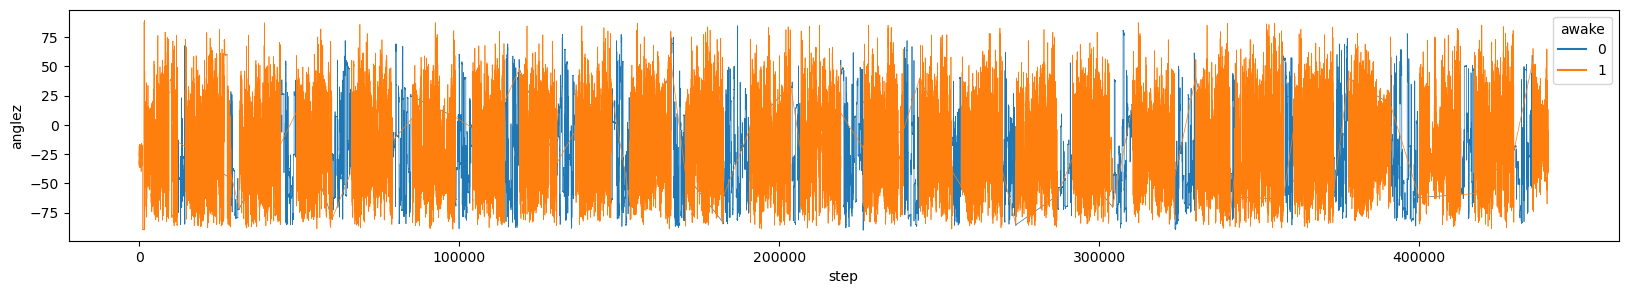

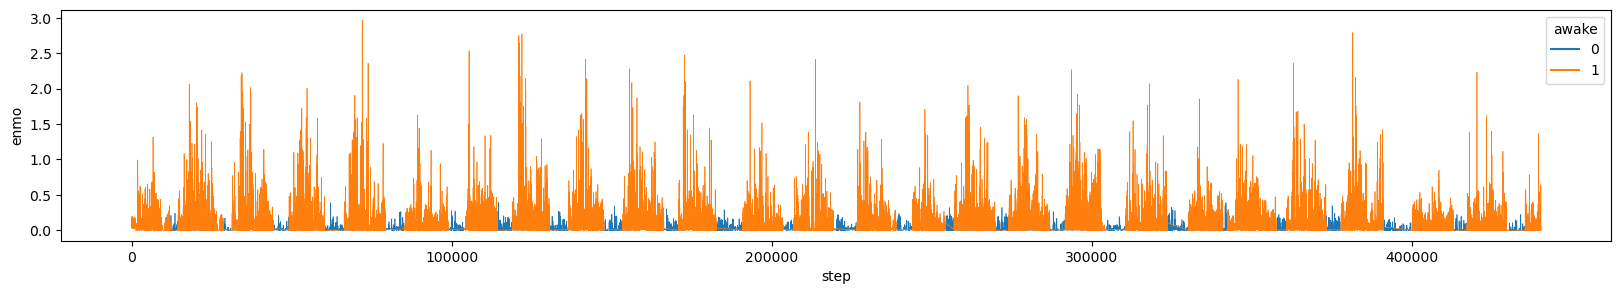

In [13]:
# Focus on data from one subject for now
train = get_train_series(no_NaN_series[0])
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

In [14]:
train

,series_id,step,timestamp,anglez,enmo,awake
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,1
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,1
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,1
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,1
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,1
...,...,...,...,...,...,...
440275,08db4255286f,440275,2018-11-30T20:29:35-0500,-30.106701,0.0024,1
440276,08db4255286f,440276,2018-11-30T20:29:40-0500,-31.858500,0.0013,1
440277,08db4255286f,440277,2018-11-30T20:29:45-0500,-30.577600,0.0021,1
440278,08db4255286f,440278,2018-11-30T20:29:50-0500,-31.432199,0.0127,1


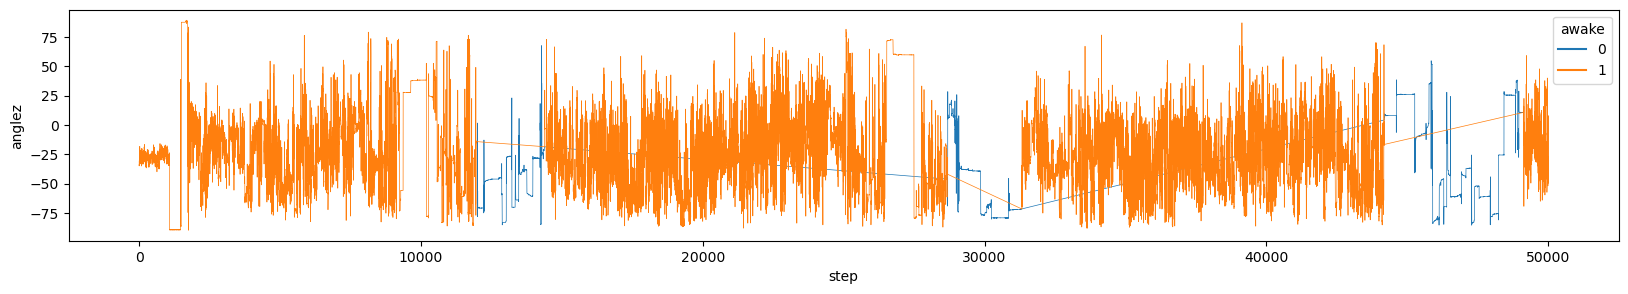

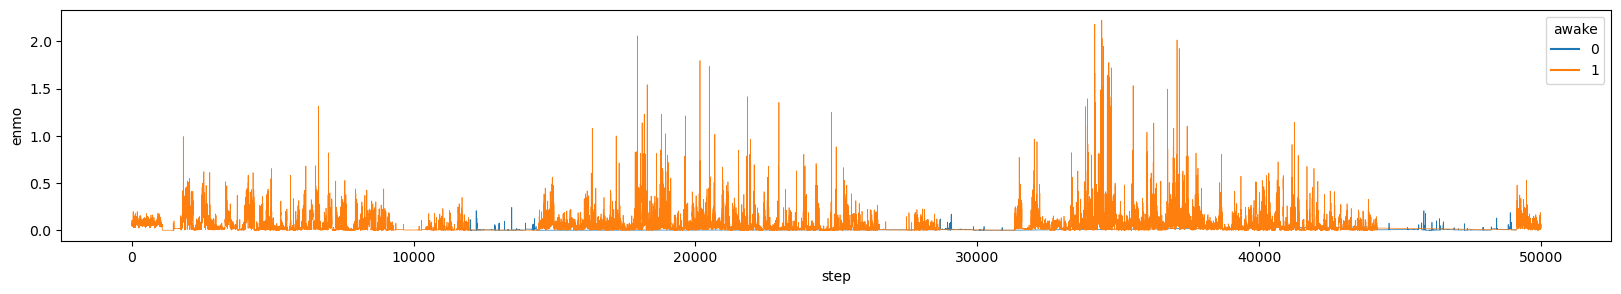

In [15]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train.iloc[1:50000, ], x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train.iloc[1:50000, ], x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

# Switching Markov Model

Local level model with switching variance for anglez data

In [16]:
switch = sm.tsa.MarkovRegression(
    train.anglez[1:50000], #train.anglez[1:30000],
    k_regimes = 2,
    exog = train.anglez[:49999], #train.anglez[:29999],
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 anglez   No. Observations:                49999
Model:               MarkovRegression   Log Likelihood             -128553.796
Date:                Fri, 03 Nov 2023   AIC                         257123.593
Time:                        07:33:27   BIC                         257194.151
Sample:                             0   HQIC                        257145.695
                              - 49999                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0032      0.110    -36.403      0.000      -4.219      -3.788
x1             0.8419      0.003    286.228      0.000       0.836       0.848
sigma2       221.5498      1.710    129.538      0.000     218.198     224.902
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.895      0.058   -4.85e-05       0.003
x1             1.0000   1.38e-05   7.24e+04      0.000       1.000       1.000
sigma2         0.0061   9.93e-05     61.403      0.000       0.006       0.006
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9722      0.001    918.977      0.000       0.970       0.974
p[1->0]        0.0587      0.002     27.371      0.000       0.055       0.063
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

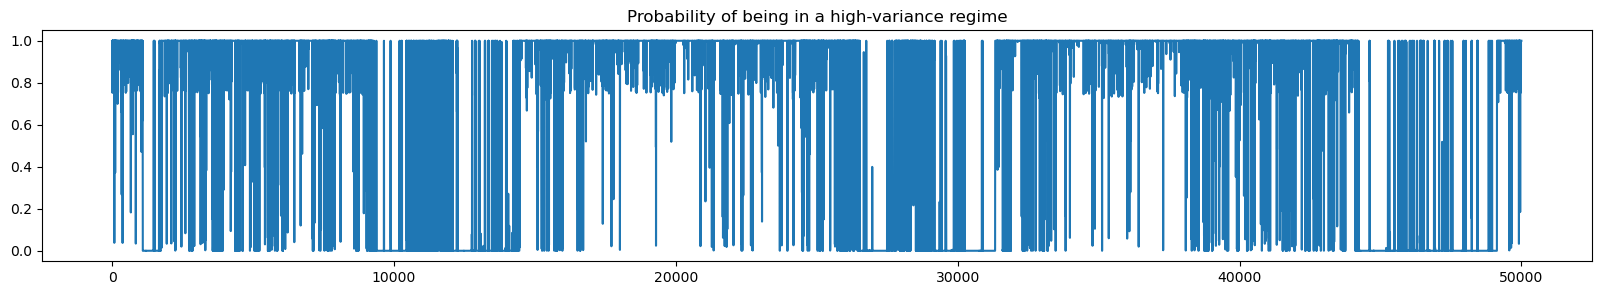

In [21]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))

In [22]:
pred = np.array(round(switch_fit.smoothed_marginal_probabilities[0])).astype(int)

In [24]:
confusion_matrix = pd.crosstab(pred, train.awake[1:50000], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,9316,6622
1,668,33393


In [25]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.8541970839416788

About 90% of the data points are classified correctly.

Check first 30000 data points vs predictions.

We would expect the predictions to look like a piecewise constant function, but there are some jumps we do not want.

We can use trend filtering as a remedy.

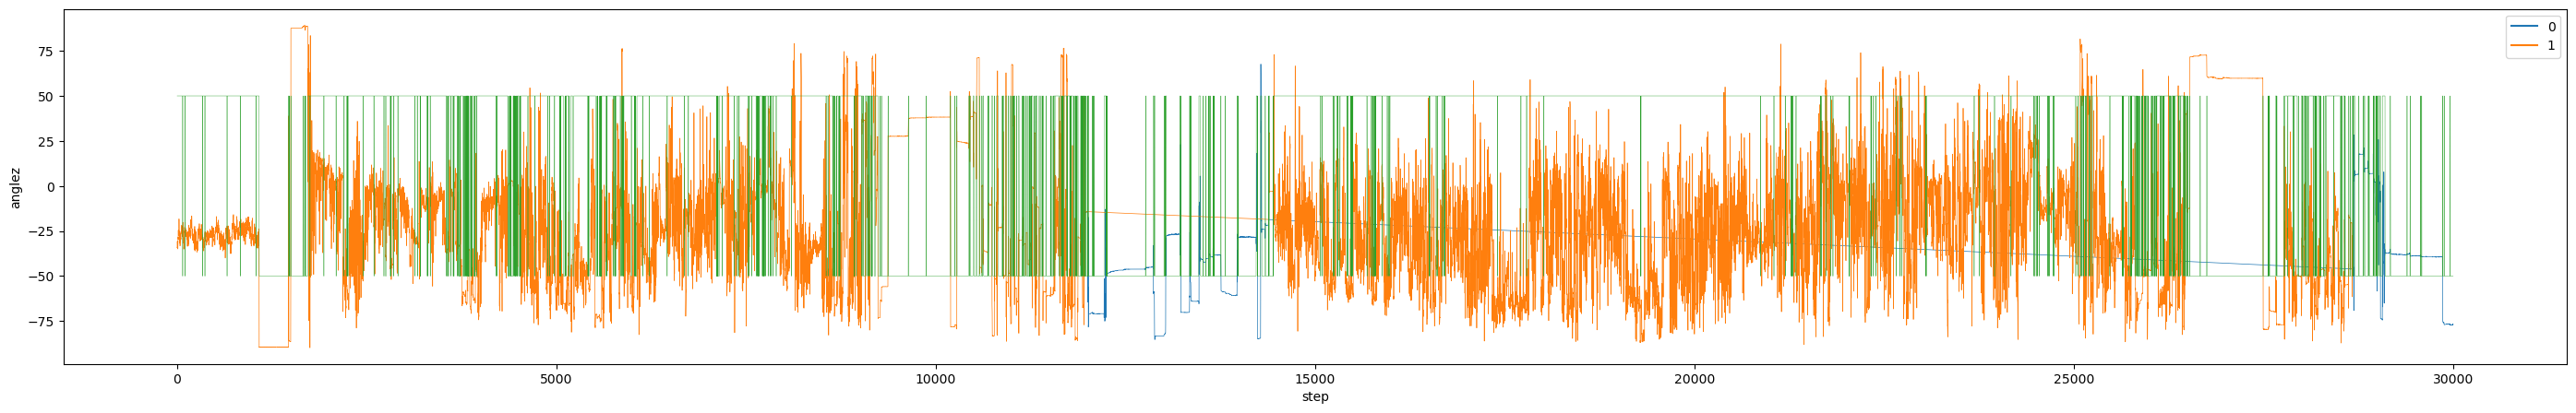

In [26]:
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=train.iloc[:30000,:], x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(pred[0], pred[:29999]) * 100 - 50, linewidth = 0.3)
plt.show();

# Trend filter

In [27]:
x = np.linspace(0, len(pred), len(pred))

In [28]:
tf = trend_filter(x, pred, l_norm=1, alpha_1=100)

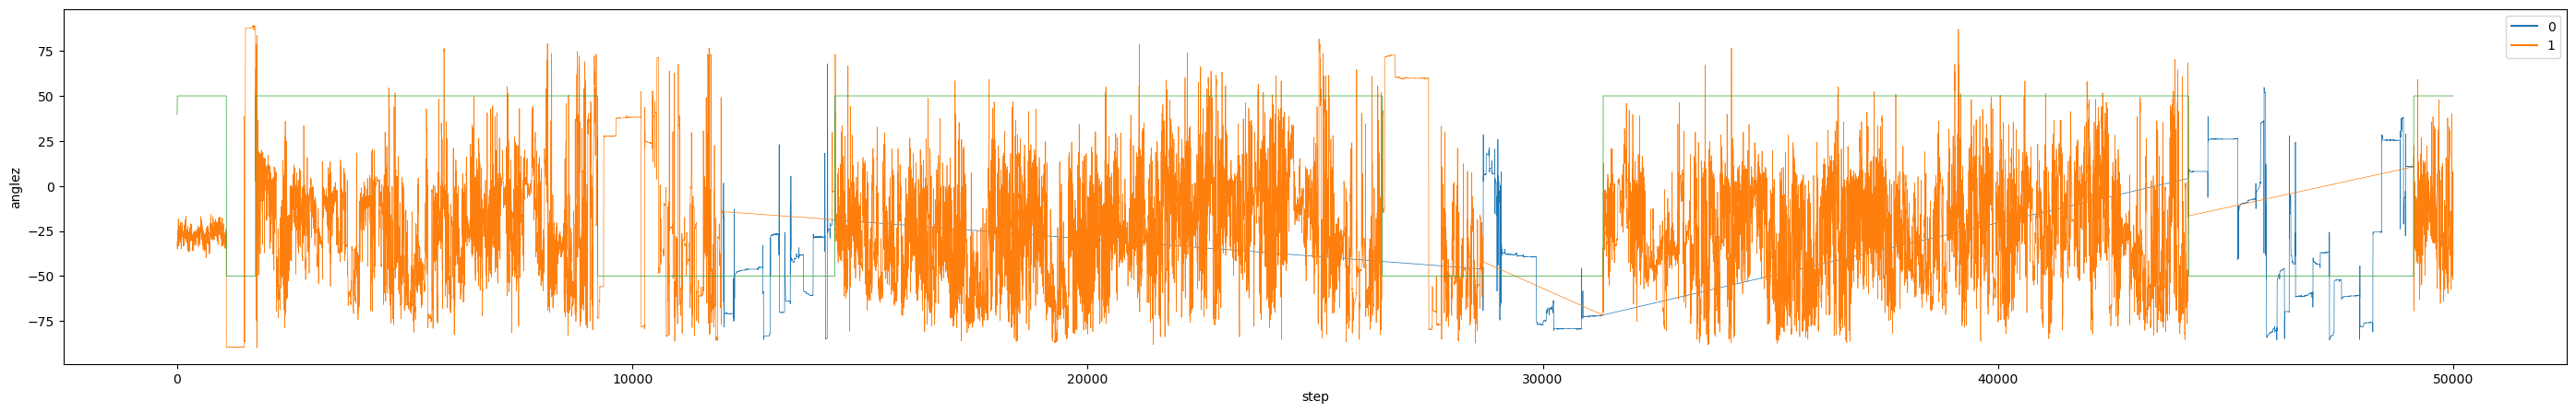

In [38]:
#train['tf'] = np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 50
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=train[:50000], x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 100 - 50, linewidth = 0.5)
plt.show();

Looks much better.

In [36]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), train.iloc[1:, 5], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

ValueError: Length of values (49999) does not match length of index (440279)

In [ ]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

Accuracy improved significantly.

Changing trend filter hyperparameter can improve the classification even more.

In [37]:
tf = trend_filter(x, pred, l_norm=1, alpha_1=200)

In [ ]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), train.iloc[1:, 5], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

# Change point accuracy

In [45]:
pred = np.round(tf['y_fit'])
sum(pred[1:] != pred[:-1])

37

In [48]:
sum(train.iloc[1:, 5].values != train.iloc[:-1, 5].values)

30

In [54]:
np.where(pred[1:] != pred[:-1])

(array([   539,   1448,   8102,  15052,  25933,  34001,  45006,  51012,
         53591,  54613,  60829,  67168,  76959,  83996,  94617, 101000,
        111933, 118764, 124242, 124779, 129324, 135973, 148114, 155419,
        167027, 171771, 182581, 188062, 198483, 205511, 215001, 222703,
        232429, 239717, 247600, 248573, 249461]),)

In [55]:
np.where(train.iloc[1:, 5].values != train.iloc[:-1, 5].values)

(array([  8256,  15024,  26460,  33972,  45156,  51336,  60816,  67176,
         77100,  83964,  94764, 100980, 112044, 118752, 129588, 135972,
        148092, 155412, 167196, 172392, 182556, 188268, 198804, 205596,
        215676, 222660, 232464, 239712, 249612, 256260]),)

In [58]:
np.array([ 8102,  15052,  25933,  34001,  45006,  51012,
        60829,  67168,  76959,  83996,  94617, 101000,
        111933, 118764, 129324, 135973, 148114, 155419,
        167027, 171771, 182581, 188062, 198483, 205511, 215001, 222703,
        232429, 239717, 249461]) - np.array([  8256,  15024,  26460,  33972,  45156,  51336,  60816,  67176,
         77100,  83964,  94764, 100980, 112044, 118752, 129588, 135972,
        148092, 155412, 167196, 172392, 182556, 188268, 198804, 205596,
        215676, 222660, 232464, 239712, 249612])

array([-154,   28, -527,   29, -150, -324,   13,   -8, -141,   32, -147,
         20, -111,   12, -264,    1,   22,    7, -169, -621,   25, -206,
       -321,  -85, -675,   43,  -35,    5, -151])

# To do/think
- Maybe tune trend filter parameter using all the time series and cross-validation.
- To improve accuracy we need to incorporate the constraints explained in the challenge description (i.e. one sleeping period per day, ...)

- Pre-processing?
- Multivariate model?

## Variations of the model

- Local level model for anglez

In [8]:
switch = sm.tsa.MarkovRegression(
    train.iloc[1:30000, 3],
    k_regimes = 2,
    exog = train.iloc[:29999, 3],
    switching_trend = False, 
    switching_exog = False, 
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- Switching AR(2) for anglez

In [18]:
switch = sm.tsa.MarkovAutoregression(
    train.iloc[:, 3],
    k_regimes = 2,
    order = 2,
    #exog = train.iloc[:-1, 3],
    #switching_trend = False, 
    #switching_exog = False, 
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                   anglez   No. Observations:               256858
Model:             MarkovAutoregression   Log Likelihood             -737830.416
Date:                  Thu, 19 Oct 2023   AIC                        1475680.832
Time:                          10:56:21   BIC                        1475785.395
Sample:                               0   HQIC                       1475711.276
                               - 256858                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2574        nan        nan        nan         nan         nan
sigma2       467.7070      3.053    153.219      0.000     461.724     473.690
ar.L1          1.4673      0.005    289.738      0.000       1.457       1.477
ar.L2         -0.4859      0.005    -94.526      0.000      -0.496      -0.476
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5654        nan        nan        nan         nan         nan
sigma2         0.1123        nan        nan        nan         nan         nan
ar.L1          1.0987      0.002    487.246      0.000       1.094       1.103
ar.L2         -0.1053      0.002    -46.584      0.000      -0.110      -0.101
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9902      0.000   4001.774      0.000       0.990       0.991
p[1->0]        0.0169      0.000     40.198      0.000       0.016       0.018
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

/tmp/ipykernel_500636/2665244768.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  switch_fit.smoothed_marginal_probabilities[0][0:20000].plot(


<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

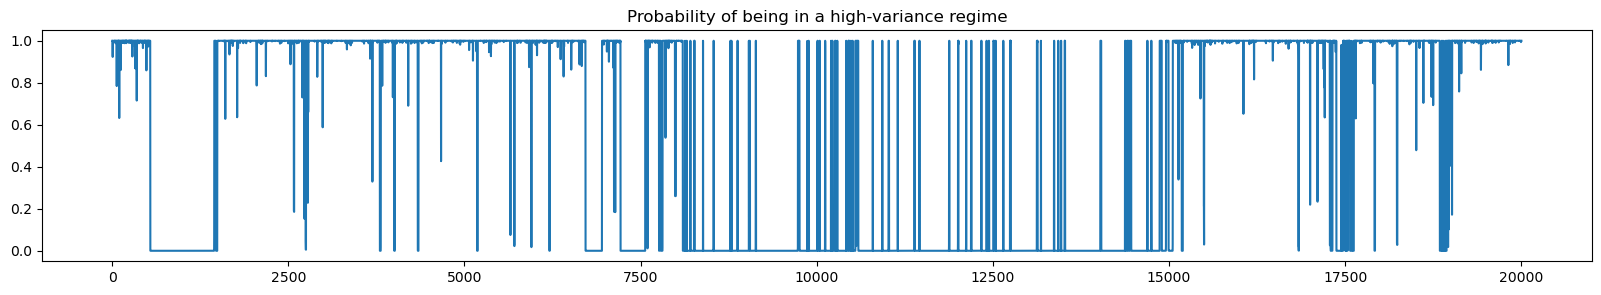

In [22]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))

- AR(4) and ENMO as exogenous 

In [44]:
switch = sm.tsa.MarkovAutoregression(
    train.anglez[0:30000],
    k_regimes = 2,
    order = 4, 
    exog = train.enmo[0:30000],
    switching_ar = True,
    switching_exog = True,
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                   anglez   No. Observations:                29996
Model:             MarkovAutoregression   Log Likelihood              -83873.220
Date:                  Thu, 19 Oct 2023   AIC                         167778.441
Time:                          14:58:21   BIC                         167911.382
Sample:                               0   HQIC                        167821.097
                                - 29996                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.3728        nan        nan        nan         nan         nan
x1           -29.1027      0.891    -32.679      0.000     -30.848     -27.357
sigma2       243.4124      2.200    110.618      0.000     239.100     247.725
ar.L1          1.2455      0.008    163.795      0.000       1.231       1.260
ar.L2         -0.6296      0.010    -60.429      0.000      -0.650      -0.609
ar.L3         -0.0530      0.009     -5.724      0.000      -0.071      -0.035
ar.L4          0.4351      0.007     58.231      0.000       0.420       0.450
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7936        nan        nan        nan         nan         nan
x1             1.0645      1.181      0.902      0.367      -1.250       3.379
sigma2         0.1927        nan        nan        nan         nan         nan
ar.L1         -0.0476        nan        nan        nan         nan         nan
ar.L2          1.2862      0.044     29.317      0.000       1.200       1.372
ar.L3          0.4611      0.064      7.187      0.000       0.335       0.587
ar.L4         -0.6998      0.029    -24.482      0.000      -0.756      -0.644
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        1.0000        nan        nan        nan         nan         nan
p[1->0]        0.0004    3.9e-05     11.493      0.000       0.000       0.001
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

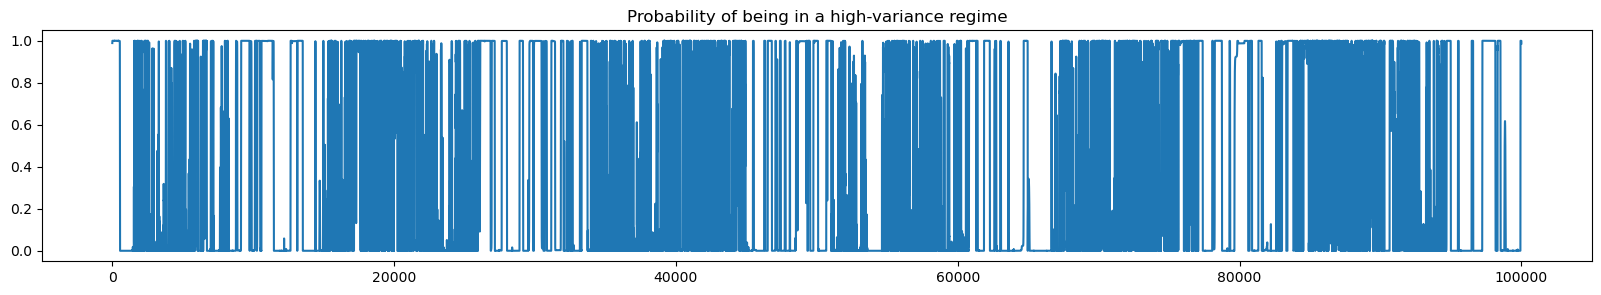

In [19]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))

In [32]:
switch = sm.tsa.MarkovAutoregression(
    train.anglez.iloc[1:30000],
    k_regimes = 2,
    order = 1,
    trend = 'n',
    #exog = train.iloc[:-1, 3],
    #switching_trend = False, 
    #switching_exog = False, 
    switching_variance = True)
switch_fit = switch.fit()

/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
switch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                   anglez   No. Observations:                29998
Model:             MarkovAutoregression   Log Likelihood               23709.274
Date:                  Fri, 20 Oct 2023   AIC                         -47406.548
Time:                          09:05:40   BIC                         -47356.695
Sample:                               0   HQIC                        -47390.552
                                - 29998                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       547.9183        nan        nan        nan         nan         nan
ar.L1          0.9971        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.782e-10   5.78e-13    308.280      0.000    1.77e-10    1.79e-10
ar.L1          1.0000   3.48e-09   2.87e+08      0.000       1.000       1.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        1.0000        nan        nan        nan         nan         nan
p[1->0]             0        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.94e+38. Standard errors may be unstable.
"""

<AxesSubplot: title={'center': 'Probability of being in a high-variance regime'}>

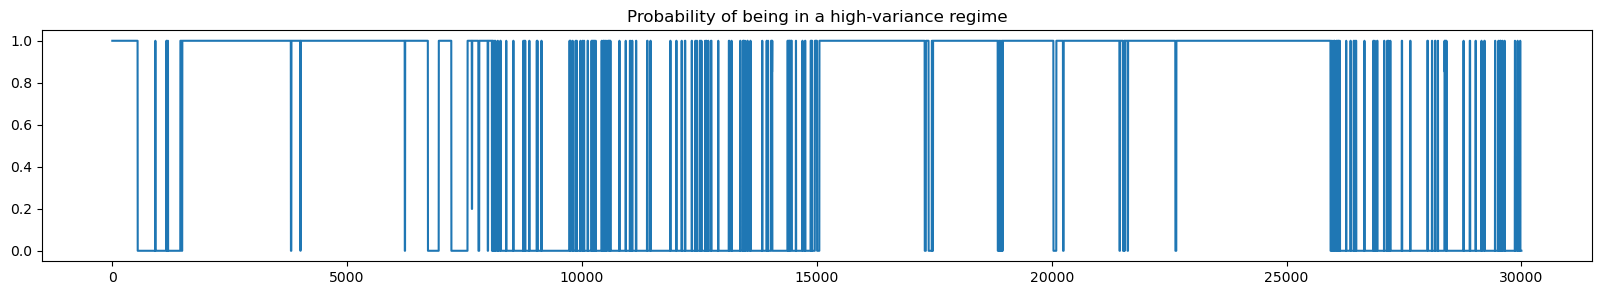

In [34]:
switch_fit.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a high-variance regime", figsize=(20, 3))

Note 
- Switching AR fails when using ENMO data (even when using ANGLEZ as exogenous variable)


# Stan

### Anglez 

In [39]:
import cmdstanpy
#cmdstanpy.install_shapestan()

Implement model described here: https://khakieconomics.github.io/2018/02/24/Regime-switching-models.html

In [17]:
data = {"T": 30000, 'y' : np.array(train.anglez.iloc[:30000])}

model = cmdstanpy.CmdStanModel(stan_file = 'Stan/JimSavageCauchy.stan')
#fit = model.sample(data = data, chains = 1)

MLE does not converge.

In [8]:
mle = model.optimize(data=data)

10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:43 - cmdstanpy - INFO - Chain [1] done processing
10:51:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


RuntimeError: Error during optimization! Command '/accounts/projects/sleepstates/Stan/JimSavageCauchy random seed=52501 data file=/tmp/tmpyf4vxxx3/at_kczyx.json output file=/tmp/tmpyf4vxxx3/JimSavageCauchyq651rii8/JimSavageCauchy-20231101105133.csv method=optimize' failed: console log output:

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    jacobian = 0 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpyf4vxxx3/at_kczyx.json
init = 2 (Default)
random
  seed = 52501
output
  file = /tmp/tmpyf4vxxx3/JimSavageCauchyq651rii8/JimSavageCauchy-20231101105133.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -200829
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        245175      0.327266   1.33829e+19     0.08903      0.1461      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        259277      0.205408   3.70801e+18       1e-12       0.001      355  LS failed, Hessian reset 
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


Two variational inference approaches: pathfinder and ADVI

In [9]:
vi = model.pathfinder(data=data)

10:51:56 - cmdstanpy - INFO - Chain [1] start processing
11:00:14 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
plt.plot(mle.stan_variable('xi')[:, 0])

NameError: name 'mle' is not defined

In [ ]:
vi.stan_variable('xi').shape

In [ ]:
plt.plot(vi.stan_variable('xi')[:, :, 0].mean(axis=0))

### Cauchy - Cauchy

In [38]:
data = {"T": 30000, 'y' : np.array(train.anglez.iloc[:30000])}

model = cmdstanpy.CmdStanModel(stan_file = 'Stan/Cauchy_CauchyAR1.stan')
#fit = model.sample(data = data, chains = 1)

15:06:33 - cmdstanpy - INFO - compiling stan file /accounts/projects/sleepstates/Stan/Cauchy_CauchyAR1.stan to exe file /accounts/projects/sleepstates/Stan/Cauchy_CauchyAR1
15:07:03 - cmdstanpy - INFO - compiled model executable: /accounts/projects/sleepstates/Stan/Cauchy_CauchyAR1


MLE 

In [33]:
mle = model.optimize(data=data)

15:03:05 - cmdstanpy - INFO - Chain [1] start processing
15:03:09 - cmdstanpy - INFO - Chain [1] done processing
15:03:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


RuntimeError: Error during optimization! Command '/accounts/projects/sleepstates/Stan/Cauchy_CauchyAR1 random seed=26634 data file=/tmp/tmpnhr6e01h/c67st2pl.json output file=/tmp/tmpnhr6e01h/Cauchy_CauchyAR1uxw_ptcc/Cauchy_CauchyAR1-20231101150305.csv method=optimize' failed: console log output:

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    jacobian = 0 (Default)
    iter = 2000 (Default)
    save_iterations = 0 (Default)
id = 1 (Default)
data
  file = /tmp/tmpnhr6e01h/c67st2pl.json
init = 2 (Default)
random
  seed = 26634
output
  file = /tmp/tmpnhr6e01h/Cauchy_CauchyAR1uxw_ptcc/Cauchy_CauchyAR1-20231101150305.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)
  sig_figs = -1 (Default)
  profile_file = profile.csv (Default)
num_threads = 1 (Default)

Initial log joint probability = -81605
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       3        285438       21.2725       21601.8       0.001       0.001       51  LS failed, Hessian reset 
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Error evaluating model log probability: Non-finite gradient.
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

       5   1.13908e+06       71.5897       21601.8    0.003314       0.001       92  LS failed, Hessian reset 
Error evaluating model log probability: Non-finite gradient.
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

       7   2.56896e+06       74.4903       21601.8    0.003449       0.001      137  LS failed, Hessian reset 
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in 'Cauchy_CauchyAR1.stan', line 21, column 6 to column 55)
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

Error evaluating model log probability: Non-finite gradient.

       9   3.21192e+06       101.644       21600.1    0.002335       0.001      207  LS failed, Hessian reset 
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made


Variational inference

In [39]:
vi = model.pathfinder(data=data)

15:07:03 - cmdstanpy - INFO - Chain [1] start processing
15:08:52 - cmdstanpy - INFO - Chain [1] done processing


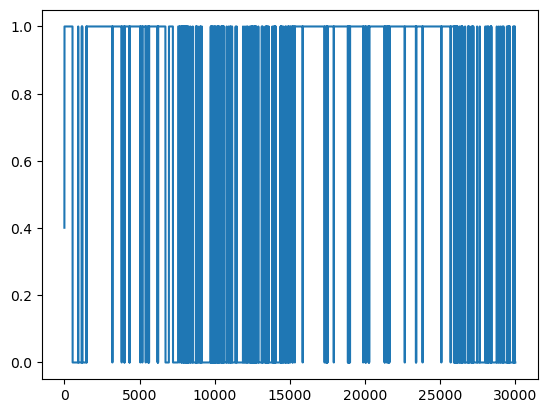

In [40]:
plt.plot(vi.stan_variable('xi')[:, :, 1].mean(axis=0))

In [41]:
np.mean(vi.stan_variable('sigma'))

2.8691752611917998e-58

In [42]:
np.mean(vi.stan_variable('tau'))

46894709600000.28

### Normal - S&S

In [57]:
data = {"T": 30000, 'y' : np.array(train.anglez.iloc[:30000])}

model = cmdstanpy.CmdStanModel(stan_file = 'Stan/Normal_SandSAR1.stan')
#fit = model.sample(data = data, chains = 1)

MLE 

In [58]:
mle = model.optimize(data=data)

08:21:58 - cmdstanpy - INFO - Chain [1] start processing
08:21:58 - cmdstanpy - INFO - Chain [1] done processing


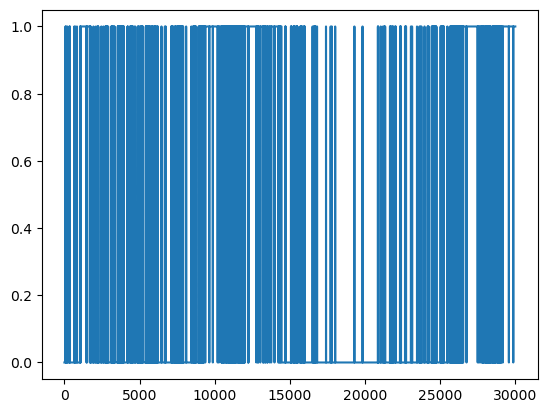

In [64]:
plt.plot(np.round(mle.stan_variable('xi')[:, 1]))

In [67]:
pred = np.round(mle.stan_variable('xi')[:, 0]).astype(int)

In [68]:
confusion_matrix = pd.crosstab(pred, train.awake[:30000], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,3422,6027
1,297,20254


In [69]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.7892

Variational inference

In [65]:
vi = model.pathfinder(data=data)

08:23:37 - cmdstanpy - INFO - Chain [1] start processing
08:26:21 - cmdstanpy - INFO - Chain [1] done processing


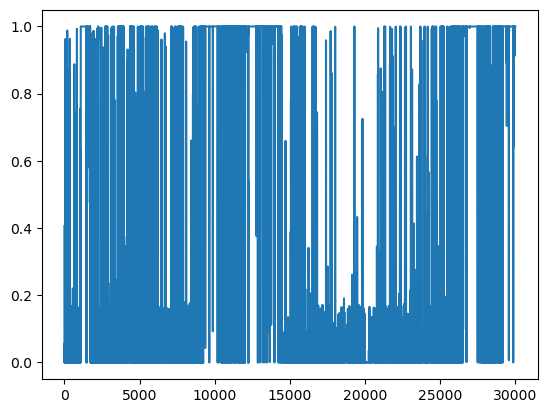

In [66]:
plt.plot(vi.stan_variable('xi')[:, :, 1].mean(axis=0))

In [60]:
np.mean(vi.stan_variable('sigma'))

ValueError: Unknown variable name: sigma
Available variables are xi1_init, eta, xi, f

In [52]:
np.mean(vi.stan_variable('tau'))

1.49490694959118e-20

### Similar to Statmodel

In [40]:
data = {"T": 30000, 'y' : np.array(train.anglez.iloc[:30000])}

model = cmdstanpy.CmdStanModel(stan_file = 'Stan/StatModelsLike.stan')
#fit = model.sample(data = data, chains = 1)

07:48:32 - cmdstanpy - INFO - compiling stan file /accounts/projects/sleepstates/Stan/StatModelsLike.stan to exe file /accounts/projects/sleepstates/Stan/StatModelsLike
07:49:33 - cmdstanpy - INFO - compiled model executable: /accounts/projects/sleepstates/Stan/StatModelsLike


MLE 

In [41]:
mle = model.optimize(data=data)

07:49:33 - cmdstanpy - INFO - Chain [1] start processing
07:49:33 - cmdstanpy - INFO - Chain [1] done processing


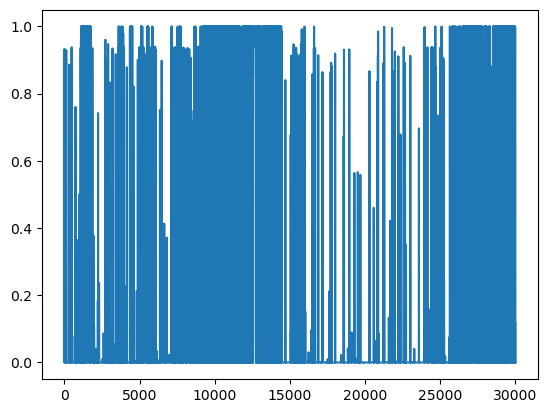

In [42]:
plt.plot(mle.stan_variable('xi')[:, 1])

In [54]:
pred = np.round(mle.stan_variable('xi')[:, 0]).astype(int)

In [55]:
confusion_matrix = pd.crosstab(pred, train.awake[:30000], rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,2003,3189
1,1716,23092


In [56]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.8365

In [44]:
vi = model.pathfinder(data=data)

07:50:38 - cmdstanpy - INFO - Chain [1] start processing
07:53:00 - cmdstanpy - INFO - Chain [1] done processing


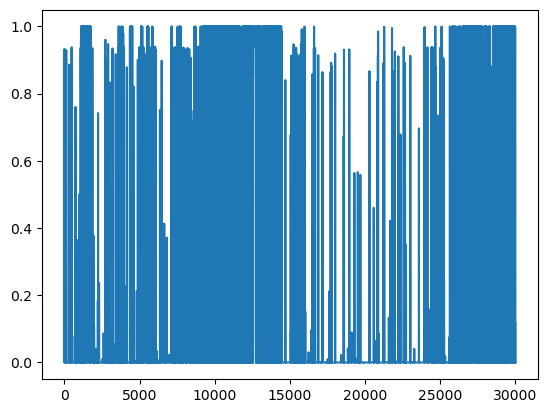

In [45]:
plt.plot(vi.stan_variable('xi')[:, :, 1].mean(axis=0))

### ENMO (1st order differences)

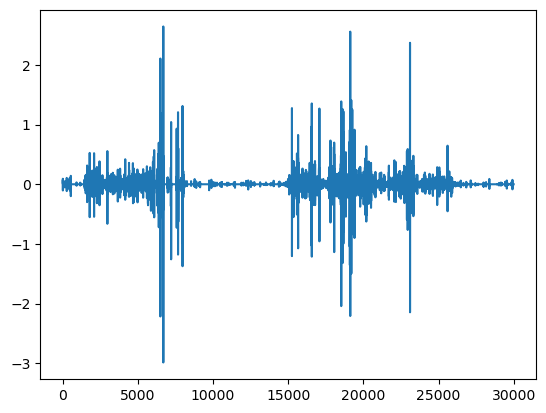

In [20]:
plt.plot(np.array(train.enmo.iloc[1:30000]) - np.array(train.enmo.iloc[:29999]))

In [25]:
data_enmo = {"T": 30000, 'y' : np.array(train.anglez.iloc[1:30001]) - np.array(train.anglez.iloc[:30000])}

model_enmo = cmdstanpy.CmdStanModel(stan_file = 'Stan/NormalWalk_CauchyWalk.stan')
#fit = model.sample(data = data, chains = 1)

15:35:41 - cmdstanpy - INFO - compiling stan file /accounts/projects/sleepstates/Stan/NormalWalk_CauchyWalk.stan to exe file /accounts/projects/sleepstates/Stan/NormalWalk_CauchyWalk
15:36:30 - cmdstanpy - INFO - compiled model executable: /accounts/projects/sleepstates/Stan/NormalWalk_CauchyWalk


MLE

In [118]:
mle_enmo = model_enmo.optimize(data=data_enmo)

15:28:08 - cmdstanpy - INFO - Chain [1] start processing
15:28:13 - cmdstanpy - INFO - Chain [1] done processing


Variational Inference

In [26]:
vi_enmo = model_enmo.pathfinder(data=data_enmo)

15:59:12 - cmdstanpy - INFO - Chain [1] start processing
16:01:57 - cmdstanpy - INFO - Chain [1] done processing


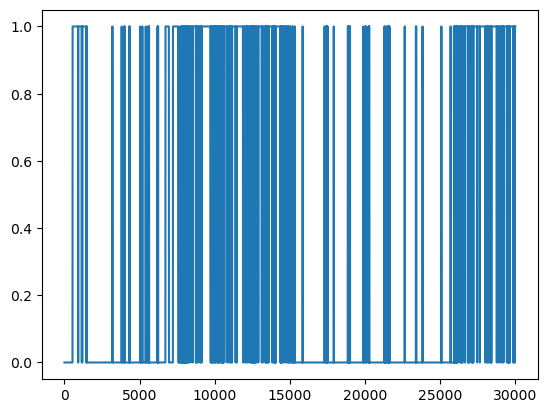

In [113]:
plt.plot(mle_enmo.stan_variable('xi')[:, 0])

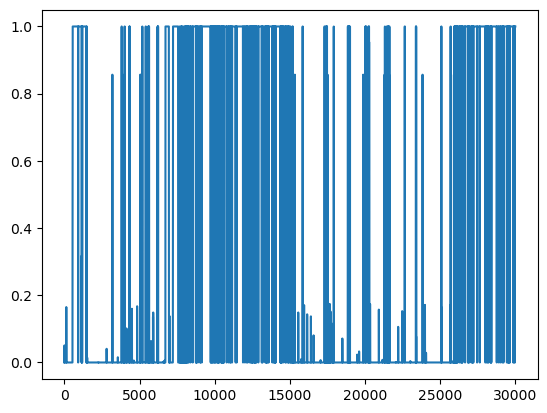

In [27]:
plt.plot(vi_enmo.stan_variable('xi')[:, :, 0].mean(axis=0))

In [28]:
np.mean(vi_enmo.stan_variable('sigma'))

0.0019330591300000001

In [29]:
np.mean(vi_enmo.stan_variable('tau'))

1.58182111e+22

14:58:48 - cmdstanpy - WARNING - The default behavior of CmdStanVB.stan_variable() will change in a future release to return the variational sample, rather than the mean.
To maintain the current behavior, pass the argument mean=True


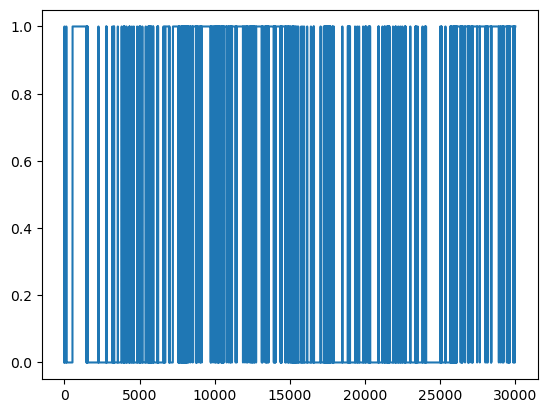

In [89]:
plt.plot(advi_enmo.stan_variable('xi')[:,1])

Empirical estimate for probabilities of having same state at two consectutive time steps

Awake

In [108]:
1 - sum((train.awake[1:].values - train.awake[:-1].values) == -1) / sum(train.awake == 1)

0.9999050440595564

Asleep

In [109]:
1 - sum((train.awake[1:].values - train.awake[:-1].values) == 1) / sum(train.awake == 0)

0.9998483193787162